In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Saderat_Bank.csv')
df

,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
0,Saderat Bank,20250205,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
1,Saderat Bank,20250204,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
2,Saderat Bank,20250203,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
3,Saderat Bank,20250202,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
4,Saderat Bank,20250201,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3782,Saderat Bank,20090614,1019.0,1026.0,1019.0,1024.0,4.085443e+10,39890423,1995,D,1023.0,1025.0
3783,Saderat Bank,20090613,1013.0,1025.0,1006.0,1023.0,1.234601e+11,120700223,5411,D,1021.0,1024.0
3784,Saderat Bank,20090610,1031.0,1031.0,1020.0,1021.0,5.489370e+10,53760812,2406,D,1001.0,1025.0
3785,Saderat Bank,20090609,1002.0,1002.0,1001.0,1001.0,9.834886e+11,982499500,545,D,1001.0,1001.0


In [5]:
df = df.drop(['<TICKER>'], axis=1)
df = df.rename(columns={'<DTYYYYMMDD>': 'date', '<HIGH>': 'high','<FIRST>' : 'first', '<LOW>': 'low', '<CLOSE>': 'close', '<VALUE>': 'value',
                        '<VOL>': 'vol', '<OPENINT>': 'openint','<PER>': 'per', '<OPEN>': 'open', '<LAST>': 'last'})

In [6]:
df

,date,first,high,low,close,value,vol,openint,per,open,last
0,20250205,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
1,20250204,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
2,20250203,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
3,20250202,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
4,20250201,0.0,0.0,0.0,611.0,0.000000e+00,0,0,D,611.0,613.0
...,...,...,...,...,...,...,...,...,...,...,...
3782,20090614,1019.0,1026.0,1019.0,1024.0,4.085443e+10,39890423,1995,D,1023.0,1025.0
3783,20090613,1013.0,1025.0,1006.0,1023.0,1.234601e+11,120700223,5411,D,1021.0,1024.0
3784,20090610,1031.0,1031.0,1020.0,1021.0,5.489370e+10,53760812,2406,D,1001.0,1025.0
3785,20090609,1002.0,1002.0,1001.0,1001.0,9.834886e+11,982499500,545,D,1001.0,1001.0


In [7]:
# Converting 'Volume' from strings with 'M' and 'B' to numerical values
df['vol'] = df['vol'].replace({'M': '*1e6', 'B': '*1e9'}, regex=True).map(pd.eval).astype(float)

# تبدیل تاریخ به فرمت datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# تبدیل ستون تاریخ به نوع datetime
df['date'] = pd.to_datetime(df['date'])

# مرتب‌سازی بر اساس تاریخ از 2009 تا 2024
df = df.sort_values(by='date', ascending=True)

# نمایش چند ردیف اول از داده‌های مرتب‌شده
df.head()


,date,first,high,low,close,value,vol,openint,per,open,last
3786,2009-06-08,0.0,0.0,0.0,1000.0,0.000000e+00,0.0,0,D,1000.0,1000.0
3785,2009-06-09,1002.0,1002.0,1001.0,1001.0,9.834886e+11,982499500.0,545,D,1001.0,1001.0
3784,2009-06-10,1031.0,1031.0,1020.0,1021.0,5.489370e+10,53760812.0,2406,D,1001.0,1025.0
3783,2009-06-13,1013.0,1025.0,1006.0,1023.0,1.234601e+11,120700223.0,5411,D,1021.0,1024.0
3782,2009-06-14,1019.0,1026.0,1019.0,1024.0,4.085443e+10,39890423.0,1995,D,1023.0,1025.0


### Scaling

In [8]:
df

,date,first,high,low,close,value,vol,openint,per,open,last
3786,2009-06-08,0.0,0.0,0.0,1000.0,0.000000e+00,0.0,0,D,1000.0,1000.0
3785,2009-06-09,1002.0,1002.0,1001.0,1001.0,9.834886e+11,982499500.0,545,D,1001.0,1001.0
3784,2009-06-10,1031.0,1031.0,1020.0,1021.0,5.489370e+10,53760812.0,2406,D,1001.0,1025.0
3783,2009-06-13,1013.0,1025.0,1006.0,1023.0,1.234601e+11,120700223.0,5411,D,1021.0,1024.0
3782,2009-06-14,1019.0,1026.0,1019.0,1024.0,4.085443e+10,39890423.0,1995,D,1023.0,1025.0
...,...,...,...,...,...,...,...,...,...,...,...
4,2025-02-01,0.0,0.0,0.0,611.0,0.000000e+00,0.0,0,D,611.0,613.0
3,2025-02-02,0.0,0.0,0.0,611.0,0.000000e+00,0.0,0,D,611.0,613.0
2,2025-02-03,0.0,0.0,0.0,611.0,0.000000e+00,0.0,0,D,611.0,613.0
1,2025-02-04,0.0,0.0,0.0,611.0,0.000000e+00,0.0,0,D,611.0,613.0


In [9]:
# Scaling the numerical features using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Selecting features for scaling (excluding Date and Percentage Change as it is in percentage form)
features_to_scale = ['close', 'open', 'high', 'low', 'vol']

# Initializing the scaler
scaler = MinMaxScaler()

# Scaling the selected features
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Displaying the first few rows to verify scaling
df[['date', 'close', 'open', 'high', 'low', 'vol']].head()


,date,close,open,high,low,vol
3786,2009-06-08,0.135968,0.135968,0.000000,0.000000,0.000000
3785,2009-06-09,0.136191,0.136191,0.196086,0.216199,0.343761
3784,2009-06-10,0.140656,0.136191,0.201761,0.220302,0.018810
3783,2009-06-13,0.141103,0.140656,0.200587,0.217279,0.042231
3782,2009-06-14,0.141326,0.141103,0.200783,0.220086,0.013957


In [10]:
# Feature Engineering

# Moving Averages
df['MA10'] = df['close'].rolling(window=10).mean()
df['MA50'] = df['close'].rolling(window=50).mean()

# Lag Features
for lag in range(1, 6):
    df[f'Lag_{lag}'] = df['close'].shift(lag)

# Volatility (Standard Deviation)
df['Volatility'] = df['close'].rolling(window=10).std()

# Drop rows with NaN values generated by feature engineering
df.dropna(inplace=True)

print(df.head())


           date  first      high       low     close         value       vol  \
3737 2009-08-19  963.0  0.191389  0.207991  0.131503  3.055110e+08  0.000110   
3736 2009-08-22  970.0  0.189824  0.207775  0.131279  4.754206e+08  0.000172   
3735 2009-08-23  970.0  0.189824  0.205616  0.130610  1.180368e+09  0.000430   
3734 2009-08-24  964.0  0.189041  0.206048  0.130163  9.687572e+08  0.000353   
3733 2009-08-25  960.0  0.188063  0.206263  0.129716  7.652826e+08  0.000279   

      openint per      open   last      MA10      MA50     Lag_1     Lag_2  \
3737       32   D  0.131503  965.0  0.131815  0.141040  0.131503  0.131726   
3736       53   D  0.131503  966.0  0.131547  0.140947  0.131503  0.131503   
3735       74   D  0.131279  960.0  0.131302  0.140835  0.131279  0.131503   
3734       62   D  0.130610  960.0  0.131190  0.140625  0.130610  0.131279   
3733       49   D  0.130163  955.0  0.131101  0.140397  0.130163  0.130610   

         Lag_3     Lag_4     Lag_5  Volatility  
3

Now the data is in ascending order according to the dates. We can go forward with model selection and training.

### Model Selection

In [11]:
stock_data = df

In [12]:
# Perform the Augmented Dickey-Fuller test to check stationarity on the 'Closing Price'
from statsmodels.tsa.stattools import adfuller

# ADF test on 'Closing Price'
adf_result = adfuller(stock_data['close'])

# Extract the results
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

adf_statistic, p_value, critical_values


(-2.692846821135236,
 0.07528428199795628,
 {'1%': -3.4321114600792098,
  '5%': -2.862318315640672,
  '10%': -2.567184308512469})

### ADF Test Results

#### ADF Statistic
- **Value**: -3.63

#### p-value
- **Value**: 0.0052

#### Critical Values
- **1%**: -3.43  
- **5%**: -2.86  
- **10%**: -2.57

### Interpretation
Since the ADF Statistic (-3.63) is lower than the critical values at all levels (1%, 5%, and 10%), and the p-value (0.0052) is less than 0.05, we can reject the null hypothesis of the ADF test.

### Conclusion
The data is stationary, which is a good sign for proceeding with an ARIMA model.


In [13]:
from statsmodels.tsa.stattools import adfuller

stock_data = df
result = adfuller(stock_data['close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.692846821135236
p-value: 0.07528428199795628


In [14]:
# Sort the data by 'Date' in ascending order
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values(by='date').reset_index(drop=False)
# بررسی مقادیر نامعتبر (NaT) پس از تبدیل به datetime
invalid_dates = df['date'].isna().sum()
print(f"Number of invalid dates: {invalid_dates}")

# نمایش چند نمونه از ردیف‌هایی که تاریخ آنها نامعتبر است
print(df[df['date'].isna()])
df = df.dropna(subset=['date'])
df
df.reset_index(inplace= True)
df.drop(columns = ['index'], inplace= True)
df


Number of invalid dates: 0
Empty DataFrame
Columns: [date, first, high, low, close, value, vol, openint, per, open, last, MA10, MA50, Lag_1, Lag_2, Lag_3, Lag_4, Lag_5, Volatility]
Index: []


,date,first,high,low,close,value,vol,openint,per,open,last,MA10,MA50,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Volatility
0,2009-08-19,963.0,0.191389,0.207991,0.131503,3.055110e+08,0.000110,32,D,0.131503,965.0,0.131815,0.141040,0.131503,0.131726,0.131726,0.131503,0.131279,0.000971
1,2009-08-22,970.0,0.189824,0.207775,0.131279,4.754206e+08,0.000172,53,D,0.131503,966.0,0.131547,0.140947,0.131503,0.131503,0.131726,0.131726,0.131503,0.000621
2,2009-08-23,970.0,0.189824,0.205616,0.130610,1.180368e+09,0.000430,74,D,0.131279,960.0,0.131302,0.140835,0.131279,0.131503,0.131503,0.131726,0.131726,0.000400
3,2009-08-24,964.0,0.189041,0.206048,0.130163,9.687572e+08,0.000353,62,D,0.130610,960.0,0.131190,0.140625,0.130610,0.131279,0.131503,0.131503,0.131726,0.000539
4,2009-08-25,960.0,0.188063,0.206263,0.129716,7.652826e+08,0.000279,49,D,0.130163,955.0,0.131101,0.140397,0.130163,0.130610,0.131279,0.131503,0.131503,0.000697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,2025-02-01,0.0,0.000000,0.000000,0.049118,0.000000e+00,0.000000,0,D,0.049118,613.0,0.049118,0.315584,0.049118,0.049118,0.049118,0.049118,0.049118,0.000000
3734,2025-02-02,0.0,0.000000,0.000000,0.049118,0.000000e+00,0.000000,0,D,0.049118,613.0,0.049118,0.310502,0.049118,0.049118,0.049118,0.049118,0.049118,0.000000
3735,2025-02-03,0.0,0.000000,0.000000,0.049118,0.000000e+00,0.000000,0,D,0.049118,613.0,0.049118,0.305202,0.049118,0.049118,0.049118,0.049118,0.049118,0.000000
3736,2025-02-04,0.0,0.000000,0.000000,0.049118,0.000000e+00,0.000000,0,D,0.049118,613.0,0.049118,0.299670,0.049118,0.049118,0.049118,0.049118,0.049118,0.000000


ARIMA

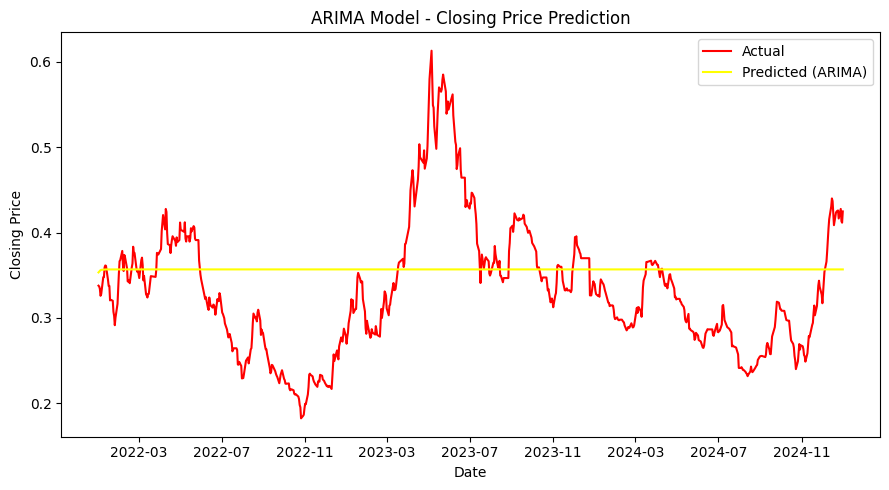

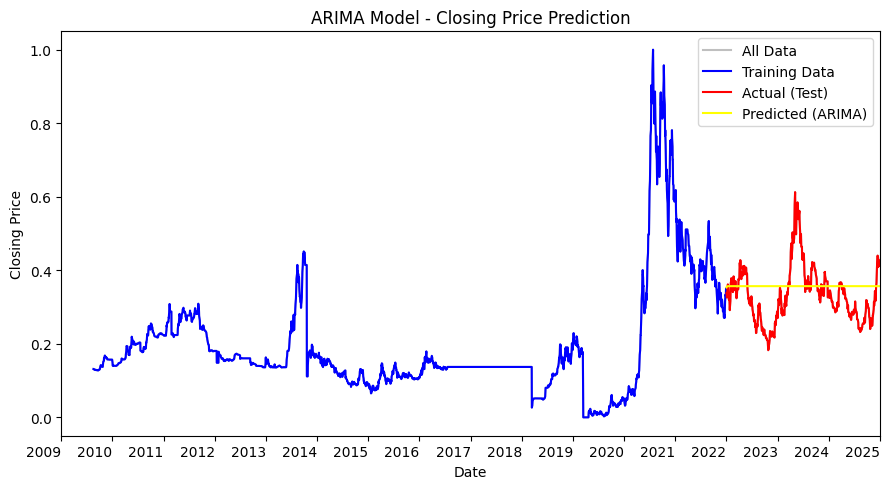

MSE: 0.006, MAE: 0.064, R-Squared: -0.109
0    0.131503
1    0.131279
2    0.130610
3    0.130163
4    0.129716
Name: close, dtype: float64
2993    0.337799
2994    0.336906
2995    0.334226
2996    0.325966
2997    0.327975
Name: close, dtype: float64
Test Dates: 2993   2022-01-01
2994   2022-01-02
2995   2022-01-03
2996   2022-01-04
2997   2022-01-05
          ...    
3709   2024-12-25
3710   2024-12-28
3711   2024-12-29
3712   2024-12-30
3713   2024-12-31
Name: date, Length: 721, dtype: datetime64[ns]


In [27]:
# Split data into training (2009-2021) and testing (2022-2024) sets
train_data = df[(df['date'] >= '2009-01-01') & (df['date'] <= '2021-12-31')]['close']
test_data = df[(df['date'] >= '2022-01-01') & (df['date'] <= '2024-12-31')]['close']

dates_test = df[(df['date'] >= '2022-01-01') & (df['date'] <= '2024-12-31')]['date']

# Fit ARIMA model (initial parameters for p, d, q can be refined later)
model_arima = ARIMA(train_data, order=(5, 1, 0))  # ARIMA(5,1,0)
arima_fit = model_arima.fit()

# Make predictions
arima_predictions = arima_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics
mse_arima = mean_squared_error(test_data, arima_predictions)
mae_arima = mean_absolute_error(test_data, arima_predictions)
rsq_arima = 1 - (sum((test_data - arima_predictions)**2) / sum((test_data - np.mean(test_data))**2))

# Plot the results
plt.figure(figsize=(9, 5))
plt.plot(dates_test, test_data, label='Actual', color='red')
plt.plot(dates_test, arima_predictions, label='Predicted (ARIMA)', color='yellow')

# Format the x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # Display every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format: Year-Month

plt.title('ARIMA Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Plot the entire dataset along with test predictions
plt.figure(figsize=(9, 5))
plt.plot(df['date'], df['close'], label='All Data', color='gray', alpha=0.5)
plt.plot(df[(df['date'] >= '2009-01-01') & (df['date'] <= '2021-12-31')]['date'],
                    train_data, label='Training Data', color='blue')
plt.plot(dates_test, test_data, label='Actual (Test)', color='red')
plt.plot(dates_test, arima_predictions, label='Predicted (ARIMA)', color='yellow')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Display major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # More detailed format: Year-Month-Day
plt.gcf().autofmt_xdate()
plt.title('ARIMA Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xlim(pd.to_datetime('2009'), pd.to_datetime('2025'))  # Set x-axis limits from 2010 to 2025
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Print evaluation metrics
print(f'MSE: {mse_arima:.3f}, MAE: {mae_arima:.3f}, R-Squared: {rsq_arima:.3f}')
print(train_data.head())
print(test_data.head())
print("Test Dates:", dates_test)



Simple ARIMA doesn't give correct output as we only predict using single variable closing price.

Now when we try using other features including Volume, Moving Average and Volatility, it gives us better predictions.  

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 0.000, MAE: 0.018, R-Squared: 0.914


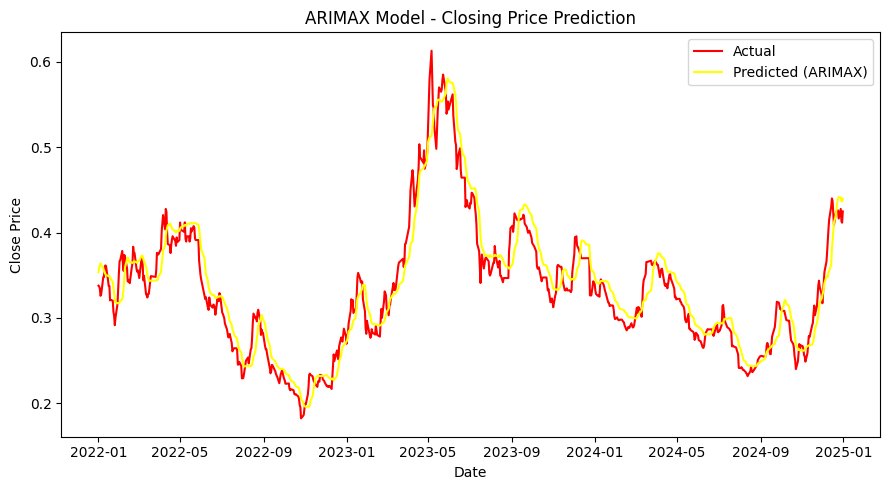

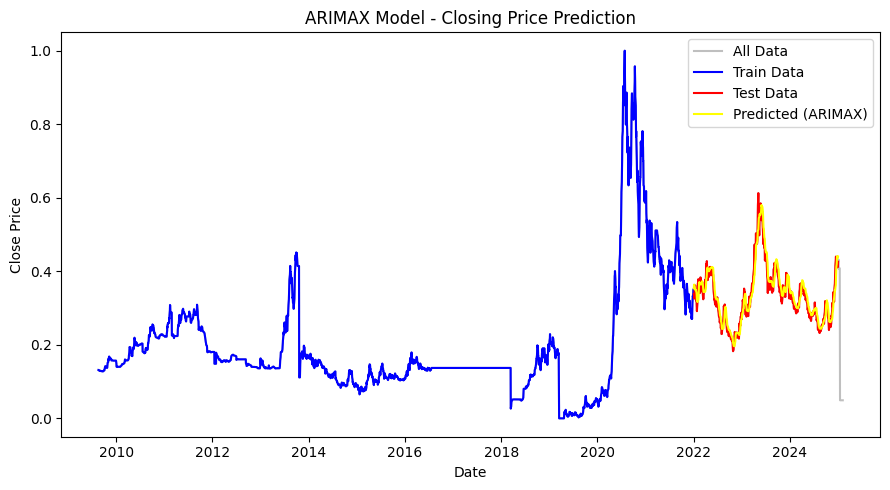

0    0.131503
1    0.131279
2    0.130610
3    0.130163
4    0.129716
Name: close, dtype: float64
2993    0.337799
2994    0.336906
2995    0.334226
2996    0.325966
2997    0.327975
Name: close, dtype: float64
Test Dates: 2993   2022-01-01
2994   2022-01-02
2995   2022-01-03
2996   2022-01-04
2997   2022-01-05
          ...    
3709   2024-12-25
3710   2024-12-28
3711   2024-12-29
3712   2024-12-30
3713   2024-12-31
Name: date, Length: 721, dtype: datetime64[ns]


In [28]:
# Define exogenous variables (for example: Volume, MA10, Volatility)
exog_train = df[(df['date'] >= '2009-01-01') & (df['date'] <= '2021-12-31')][['vol', 'MA10', 'Volatility']]
exog_test = df[(df['date'] >= '2022-01-01') & (df['date'] <= '2024-12-31')][['vol', 'MA10', 'Volatility']]

# Fit ARIMAX model
model_arimax = ARIMA(train_data, exog=exog_train, order=(3, 0, 3))  # تنظیم مقادیر p, d, q
arimax_fit = model_arimax.fit()

# Make predictions using exogenous variables for the test set
arimax_predictions = arimax_fit.forecast(steps=len(test_data), exog=exog_test)

# Evaluate performance
mse_arimax = mean_squared_error(test_data, arimax_predictions)
mae_arimax = mean_absolute_error(test_data, arimax_predictions)
rsq_arimax = 1 - (sum((test_data - arimax_predictions)**2) / sum((test_data - np.mean(test_data))**2))

print(f'MSE: {mse_arimax:.3f}, MAE: {mae_arimax:.3f}, R-Squared: {rsq_arimax:.3f}')

# Plot the results
plt.figure(figsize=(9, 5))
plt.plot(dates_test, test_data, label='Actual', color='red')
plt.plot(dates_test, arimax_predictions, label='Predicted (ARIMAX)', color='yellow')
plt.title('ARIMAX Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Plot ALL results
plt.figure(figsize=(9, 5))
plt.plot(df['date'], df['close'], label='All Data', color='gray', alpha=0.5)
plt.plot(stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['date'],
         train_data, label='Train Data', color='blue')
plt.plot(dates_test, test_data, label='Test Data', color='red')
plt.plot(dates_test, arimax_predictions, label='Predicted (ARIMAX)', color='yellow')
plt.title('ARIMAX Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(train_data.head())
print(test_data.head())
print("Test Dates:", dates_test)

We can see that ARIMA with other features gave us good results. But We can't take Volume and Variability features, as they won't be available to us during predictions.

Hence we try to do predictions using Lag.

In [17]:


# exog_train = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')][['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']]
# exog_test = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')][['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']]

# # Fit ARIMAX model with lagged features as exogenous variables
# model_arimax = ARIMA(train_data, exog=exog_train, order=(5, 0, 0))  # تنظیم مقادیر p, d, q
# arimax_fit = model_arimax.fit()

# # Make predictions using exogenous variables for the test set
# arimax_predictions = arimax_fit.forecast(steps=len(test_data), exog=exog_test)

# # Evaluate performance
# mse_arimax = mean_squared_error(test_data, arimax_predictions)
# mae_arimax = mean_absolute_error(test_data, arimax_predictions)
# rsq_arimax = 1 - (sum((test_data - arimax_predictions)**2) / sum((test_data - np.mean(test_data))**2))

# print(f'MSE(ARIMAX): {mse_arimax:.4f}, MAE(ARIMAX): {mae_arimax:.4f}, R-Squared(ARIMAX): {rsq_arimax:.4f}')

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(dates_test, test_data, label='Actual', color='blue')
# plt.plot(dates_test, arimax_predictions, label='Predicted (ARIMAX)', color='red')
# plt.title('ARIMAX Model - Closing Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.xticks(rotation=0)
# plt.tight_layout()
# plt.show()


# # Plot the results
# plt.figure(figsize=(9, 5))

# # Plot all data
# plt.plot(df['date'], df['close'], label='All Data', color='gray', alpha=0.5)

# # Plot training data
# plt.plot(df[(df['date'] >= '2009-01-01') & (df['date'] <= '2021-12-31')]['date'],
#            train_data, label='Training Data', color='blue')

# # Plot actual test data
# plt.plot(dates_test, test_data, label='Actual (Test)', color='red')

# # Plot ARIMAX predictions on the test data
# plt.plot(dates_test, arimax_predictions, label='Predicted (ARIMAX)', color='yellow')

# # Set x-axis limits
# plt.xlim(pd.to_datetime('2009-01-01'), pd.to_datetime('2025-01-01'))

# plt.title('ARIMAX Model - Closing Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.xticks(rotation=0)
# plt.tight_layout()
# plt.show()

# print(train_data.head())
# print(test_data.head())
# print("Test Dates:", dates_test)



In [18]:
# Prepare the data for LSTM
def create_dataset(data, time_step=90):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

# Ensure the 'date' column is in datetime format
# stock_data['date'] = pd.to_datetime(stock_data['date'], errors='coerce')
# stock_data = stock_data.dropna(subset=['date'])  # حذف مقادیر نامعتبر
# stock_data = stock_data.sort_values('date')  # مرتب‌سازی بر اساس تاریخ

# Split data into training (2009-2021) and testing (2022-2024) sets
train_data = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['close']
test_data = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['close']

dates_test = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['date']

# Scaling the 'Closing Price' column between 0 and 1 for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Create the LSTM input dataset
time_step = 35
X_train, Y_train = create_dataset(scaled_train_data, time_step)
X_test, Y_test = create_dataset(scaled_test_data, time_step)

# Reshaping input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### LSTM

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0162 - val_loss: 0.0025
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.9648e-04 - val_loss: 0.0021
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.3701e-04 - val_loss: 0.0017
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.2043e-04 - val_loss: 0.0026
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.9722e-04 - val_loss: 0.0015
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 6.9777e-04 - val_loss: 0.0011
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.4769e-04 - val_loss: 0.0011
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.8496e-04 - val_loss: 0.0012
Epoch 9/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.4860e-04 - val_loss: 9.0772e-04
Epoch 10/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.6308e-04 - val_loss: 9.4532e-04
Epoch 11/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.9634e-04 - val_loss: 8.1210e-04
Epoch 12/200

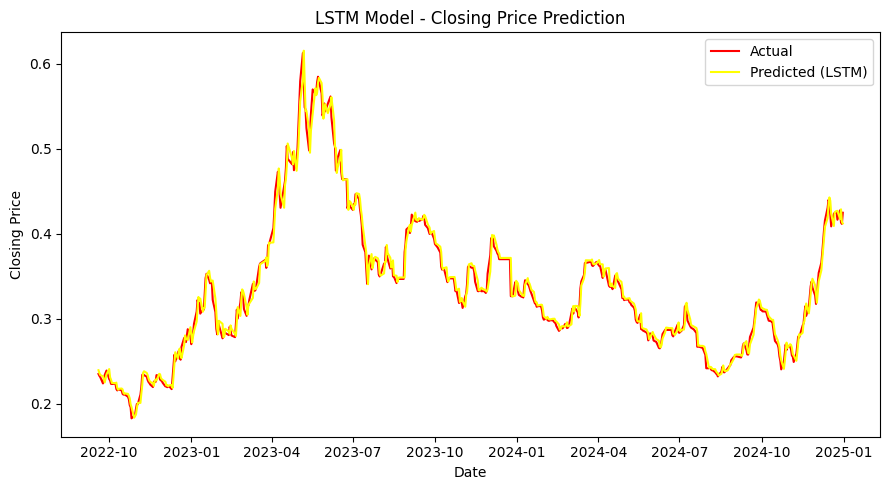

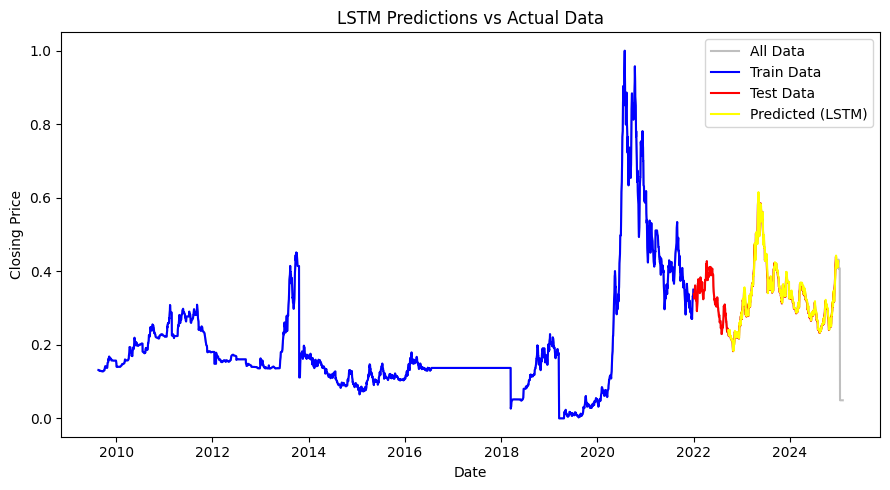

MSE (LSTM): 0.00009
MAE (LSTM): 0.00715
R-Squared (LSTM): 0.98601
0    0.131503
1    0.131279
2    0.130610
3    0.130163
4    0.129716
Name: close, dtype: float64
2993    0.337799
2994    0.336906
2995    0.334226
2996    0.325966
2997    0.327975
Name: close, dtype: float64
Test Dates: 2993   2022-01-01
2994   2022-01-02
2995   2022-01-03
2996   2022-01-04
2997   2022-01-05
          ...    
3709   2024-12-25
3710   2024-12-28
3711   2024-12-29
3712   2024-12-30
3713   2024-12-31
Name: date, Length: 721, dtype: datetime64[ns]


In [24]:
# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.1))  # کاهش Dropout
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1))

# Compile the LSTM model with custom optimizer
optimizer = Adam(learning_rate=0.001)  # افزایش نرخ یادگیری
model_lstm.compile(loss='mean_squared_error', optimizer=optimizer)

# Early Stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # افزایش patience

# Train the LSTM model
history = model_lstm.fit(
    X_train, Y_train,
    epochs=200, batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# # Plot training and validation loss
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Train Loss', color='blue')
# plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# Predict on test data
lstm_predictions = model_lstm.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Inverse scaling for actual test values
Y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate evaluation metrics for LSTM
mse_lstm = mean_squared_error(Y_test_scaled, lstm_predictions)
mae_lstm = mean_absolute_error(Y_test_scaled, lstm_predictions)

ss_res = np.sum((Y_test_scaled - lstm_predictions) ** 2)
ss_tot = np.sum((Y_test_scaled - np.mean(Y_test_scaled)) ** 2)
rsq_lstm = 1 - (ss_res / ss_tot)

# Plot the LSTM results
plt.figure(figsize=(9, 5))
plt.plot(dates_test[time_step:], Y_test_scaled, label='Actual', color='red')
plt.plot(dates_test[time_step:], lstm_predictions, label='Predicted (LSTM)', color='yellow')
plt.title('LSTM Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot the results
# Display all data in gray

# Plot the results
plt.figure(figsize=(9, 5))

# Display all data in gray
plt.plot(df['date'], df['close'], label='All Data', color='gray', alpha=0.5)

# Display training data in blue
plt.plot(df[(df['date'] >= '2009-01-01') & (df['date'] <= '2021-12-31')]['date'],
         train_data, label='Train Data', color='blue')

# Display test data in red
plt.plot(dates_test, test_data, label='Test Data', color='red')

# Display predicted values in yellow, adjusting dates to match predictions
plt.plot(dates_test[time_step:], lstm_predictions, label='Predicted (LSTM)', color='yellow')
plt.title('LSTM Predictions vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
# Print evaluation metrics
print(f"MSE (LSTM): {mse_lstm:.5f}")
print(f"MAE (LSTM): {mae_lstm:.5f}")
print(f"R-Squared (LSTM): {rsq_lstm:.5f}")
print(train_data.head())
print(test_data.head())
print("Test Dates:", dates_test)


### GRU

In [20]:
# Prepare the data for LSTM
def create_dataset(data, time_step=180):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

# Ensure the 'date' column is in datetime format
# stock_data['date'] = pd.to_datetime(stock_data['date'], errors='coerce')
# stock_data = stock_data.dropna(subset=['date'])  # حذف مقادیر نامعتبر
# stock_data = stock_data.sort_values('date')  # مرتب‌سازی بر اساس تاریخ

# Split data into training (2009-2021) and testing (2022-2024) sets
train_data = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['close']
test_data = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['close']

dates_test = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['date']

# Scaling the 'Closing Price' column between 0 and 1 for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Create the LSTM input dataset
time_step = 35
X_train, Y_train = create_dataset(scaled_train_data, time_step)
X_test, Y_test = create_dataset(scaled_test_data, time_step)

# Reshaping input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0169 - val_loss: 0.0017
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 9.9461e-04 - val_loss: 0.0015
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.5148e-04 - val_loss: 0.0012
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.2513e-04 - val_loss: 0.0016
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.1927e-04 - val_loss: 0.0013
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0011 - val_loss: 9.3181e-04
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.3644e-04 - val_loss: 8.7687e-04
Epoch 9/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.9649e-04 - val_loss: 0.0026
Epoch 10/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.0842e-04 - val_loss: 0.0016
Epoch 11/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8.3146e-04 - val_loss: 7.4517e-04
Epoch 12/200
80/80 ━

<Figure size 900x500 with 0 Axes>

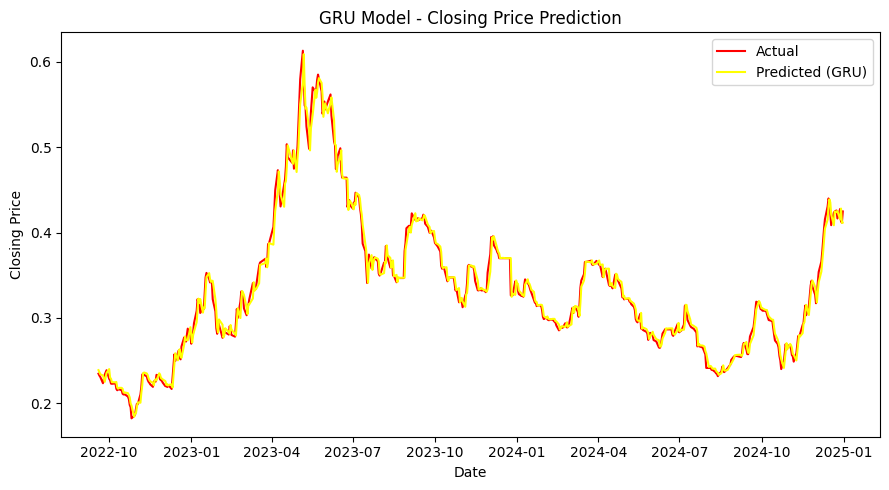

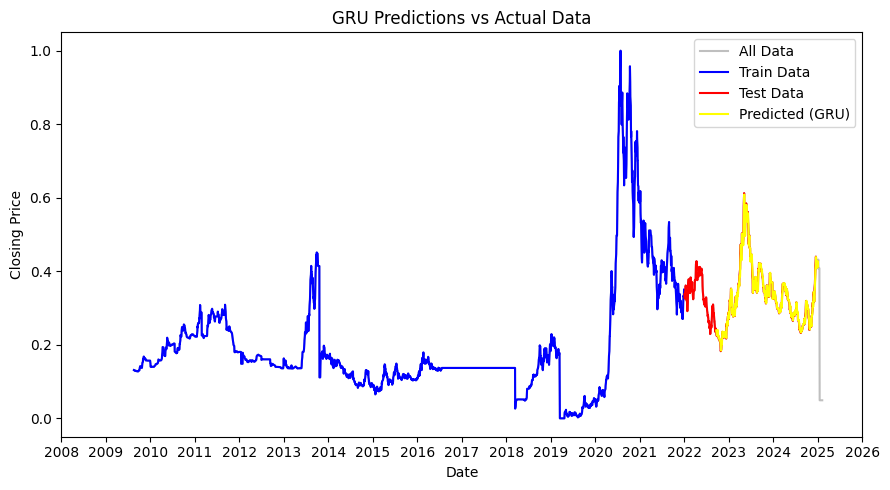

MSE (GRU): 0.0000933
MAE (GRU): 0.0069102
R-Squared (GRU): 0.98609
0    0.131503
1    0.131279
2    0.130610
3    0.130163
4    0.129716
Name: close, dtype: float64
2993    0.337799
2994    0.336906
2995    0.334226
2996    0.325966
2997    0.327975
Name: close, dtype: float64
Test Dates: 2993   2022-01-01
2994   2022-01-02
2995   2022-01-03
2996   2022-01-04
2997   2022-01-05
          ...    
3709   2024-12-25
3710   2024-12-28
3711   2024-12-29
3712   2024-12-30
3713   2024-12-31
Name: date, Length: 721, dtype: datetime64[ns]


In [25]:

# Prepare the data for GRU
def create_dataset(data, time_step=90):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

# Ensure the 'date' column is in datetime format
# stock_data['date'] = pd.to_datetime(stock_data['date'], errors='coerce')
# stock_data = stock_data.dropna(subset=['date'])  # حذف مقادیر نامعتبر
# stock_data = stock_data.sort_values('date')  # مرتب‌سازی بر اساس تاریخ

# Split data into training (2009-2021) and testing (2022-2024) sets
# train_data = stock_data[(stock_data['date'] >= '2009-01-01') & (stock_data['date'] <= '2021-12-31')]['close']
# test_data = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['close']

# dates_test = stock_data[(stock_data['date'] >= '2022-01-01') & (stock_data['date'] <= '2024-12-31')]['date']

# Scaling the 'Closing Price' column between 0 and 1 for GRU
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
# scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Create the GRU input dataset
time_step = 170  # وابستگی طولانی‌تر
X_train, Y_train = create_dataset(scaled_train_data, time_step)
X_test, Y_test = create_dataset(scaled_test_data, time_step)

# Reshaping input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build Enhanced GRU model
model_gru = Sequential()
model_gru.add(GRU(units=128, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=32))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(1))

# Compile the GRU model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # کاهش نرخ یادگیری به مقدار مناسب
model_gru.compile(loss='mean_squared_error', optimizer=optimizer)

# Early Stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the GRU model
history = model_gru.fit(X_train, Y_train,
                        epochs=200,  # تنظیم تعداد ایپاک‌ها
                        batch_size=32,  # تنظیم سایز بچ
                        validation_split=0.1,
                        callbacks=[early_stop],
                        verbose=1)

# Predict on test data
gru_predictions = model_gru.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

# Inverse scaling for actual test values
Y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate evaluation metrics for GRU
mse_gru = mean_squared_error(Y_test_scaled, gru_predictions)
mae_gru = mean_absolute_error(Y_test_scaled, gru_predictions)

# Calculate R-Squared
ss_res = np.sum((Y_test_scaled - gru_predictions) ** 2)
ss_tot = np.sum((Y_test_scaled - np.mean(Y_test_scaled)) ** 2)
rsq_gru = 1 - (ss_res / ss_tot)

# Calculate the number of predictions
num_predictions = len(gru_predictions)

# Adjust dates_test for plotting the predictions
adjusted_dates_test = dates_test[time_step:time_step + num_predictions]  # Ensure the length matches

# Plot the GRU results
# Assuming you confirmed the lengths and adjusted accordingly
plt.figure(figsize=(9, 5))
# plt.plot(adjusted_dates_test[:len(Y_test_scaled[time_step:time_step + num_predictions])],
#          Y_test_scaled[time_step:time_step + num_predictions],
#          label='Actual', color='blue')
# plt.plot(adjusted_dates_test, gru_predictions, label='Predicted (GRU)', color='red')
# plt.title('GRU Model - Closing Price Prediction')
# plt.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Move legend to the right
# plt.show()
plt.figure(figsize=(9, 5))
plt.plot(dates_test[time_step:], Y_test_scaled, label='Actual', color='red')
plt.plot(dates_test[time_step:], gru_predictions, label='Predicted (GRU)', color='yellow')
plt.title('GRU Model - Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot the results with all data
plt.figure(figsize=(9, 5))
plt.plot(df['date'], df['close'], label='All Data', color='gray', alpha=0.5)
plt.plot(df[(df['date'] >= '2009-01-01') & (df['date'] <= '2021-12-31')]['date'],
         train_data, label='Train Data', color='blue')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())# Display major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# More detailed format: Year-Month-Day
plt.plot(dates_test, test_data, label='Test Data', color='red')
plt.plot(adjusted_dates_test, gru_predictions, label='Predicted (GRU)', color='yellow')
plt.title('GRU Predictions vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xlim(pd.to_datetime('2008'),pd.to_datetime('2026'))# Set x-axis limits from 2010 to 2025
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Move legend to the right
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print evaluation metrics
print(f"MSE (GRU): {mse_gru:.7f}")
print(f"MAE (GRU): {mae_gru:.7f}")
print(f"R-Squared (GRU): {rsq_gru:.5f}")
print(train_data.head())
print(test_data.head())
print("Test Dates:", dates_test)
